<a href="https://colab.research.google.com/github/EfanovNikita/k_mean_cluster/blob/master/k_means_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/Mall_Customers.csv

--2025-04-04 08:46:24--  https://storage.yandexcloud.net/academy.ai/Mall_Customers.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3981 (3.9K) [text/csv]
Saving to: ‘Mall_Customers.csv’

Mall_Customers.csv  100%[===================>]   3.89K  --.-KB/s    in 0s      

2025-04-04 08:46:25 (950 MB/s) - ‘Mall_Customers.csv’ saved [3981/3981]



In [ ]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
data = pd.read_csv('Mall_Customers.csv')

In [ ]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(data[["Age", "Annual Income (k$)", "Spending Score (1-100)"]])

In [ ]:
class KmeansPP:
    def __init__(self, n_clusters=3, max_iters=100):
        self.n_clusters = n_clusters # количество кластеров
        self.max_iters = max_iters   # максимальное количество итераций
        self.labels = None           # инициализация меток кластеров
        self.centroids = None        # инициализация центроидов

    def initialize_centroids(self, X):
        # K-means++ инициализация
        centroids = [X[np.random.randint(X.shape[0])]]  # выбираем первый центроид случайным образом

        for _ in range(self.n_clusters - 1):
            distances = np.array([min([np.sum((x-c)**2) for c in centroids]) for x in X])  # вычисляем расстояния до ближайшего центроида
            probabilities = distances / distances.sum()  # вычисляем вероятности выбора точек
            next_centroid = X[np.random.choice(len(X), p=probabilities)]  # выбираем следующий центроид
            centroids.append(next_centroid)

        return np.array(centroids)

    def assign_clusters(self, X):
        # Проверка, что центроиды инициализированы
        if self.centroids is None:
            self.centroids = self.initialize_centroids(X)

        # Назначение точек ближайшим центроидам
        distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))  # вычисляем расстояния до всех центроидов
        return np.argmin(distances, axis=0)  # назначаем точку ближайшему центроиду

    def update_centroids(self, X):
        # Обновление позиций центроидов
        new_centroids = np.array([X[self.labels == k].mean(axis=0) for k in range(self.n_clusters)])  # вычисляем новые центроиды как среднее по точкам кластера
        return new_centroids

    def fit(self, X):
        self.centroids = self.initialize_centroids(X)  # инициализация центроидов

        for _ in range(self.max_iters):
            old_centroids = self.centroids.copy()  # сохраняем старые центроиды
            self.labels = self.assign_clusters(X)  # назначаем точки кластерам
            self.centroids = self.update_centroids(X)  # обновляем центроиды

            # Проверка сходимости
            if np.all(old_centroids == self.centroids):  # если центроиды не изменились, завершаем итерации
                break

        return self

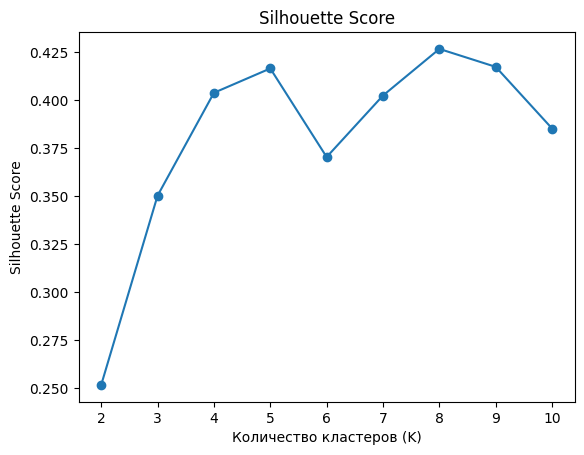

In [ ]:
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=20)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.plot(range(2, 11),silhouette_scores, marker='o')
plt.xlabel('Количество кластеров (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

In [ ]:
def KMeans_draw_plot(n_clusters=8, random_state=42):
    # Кластеризация
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)

    kmeans.fit(X)
    labels = kmeans.labels_              # метки классов
    centroids = kmeans.cluster_centers_  # центроиды

    # отображаем графики
    fig = px.scatter_3d(x=data['Age'],
                        y=data['Annual Income (k$)'],
                        z=data['Spending Score (1-100)'],
                        labels={'x': 'Возраст', 'y': 'Доход', 'z': 'Оценка'},
                        color=labels.astype(str),
                        title=f'Kmeans (clusters={n_clusters}, random_state={random_state})')

    centroids = scaler.inverse_transform(centroids) # проводим обратную нормализацию
    fig.add_scatter3d(x=centroids[:, 0],
                      y=centroids[:, 1],
                      z=centroids[:, 2],
                      name = 'Центроиды',
                      mode = 'markers',
                      marker={
                          'color': 'black',
                          'symbol': 'cross',
                      })
    fig.show()

    return kmeans

In [ ]:
kmeans_20 = KMeans_draw_plot(random_state=20)

In [ ]:
kmeans_17 = KMeans_draw_plot(random_state=17)

In [ ]:
kmeans_25 = KMeans_draw_plot(random_state=25)

In [ ]:
kmeans_60 = KMeans_draw_plot(random_state=60)

In [ ]:
def KmeansPP_draw_plot(n_clusters=8):

    customKmeans = KmeansPP(n_clusters=n_clusters)

    customKmeans.fit(X)
    labels = customKmeans.labels       # метки
    centroids = customKmeans.centroids # центроиды

    fig = px.scatter_3d(x=data['Age'],
                        y=data['Annual Income (k$)'],
                        z=data['Spending Score (1-100)'],
                        labels={'x': 'Возраст', 'y': 'Доход', 'z': 'Оценка'},
                        color=labels.astype(str),
                        title=f'Kmeans++ (clusters={n_clusters})')

    centroids = scaler.inverse_transform(centroids)
    fig.add_scatter3d(x=centroids[:, 0],
                      y=centroids[:, 1],
                      z=centroids[:, 2],
                      name = 'Центроиды',
                      mode = 'markers',
                      marker={
                          'color': 'black',
                          'symbol': 'cross',
                      })
    fig.show()

    return customKmeans

In [ ]:
kmeansPP_1 = KmeansPP_draw_plot()

In [ ]:
kmeansPP_2 = KmeansPP_draw_plot()

In [ ]:
kmeansPP_3 = KmeansPP_draw_plot()

Как видно из графиков выше результат kmeans++ метод для 8 кластеров выдает разный результат при повторных запусках, что говорит о его нестабильности. Такая же ситуация и с обычным kmeans на 8 кластеров. Для разных random_state получаются разные результаты.

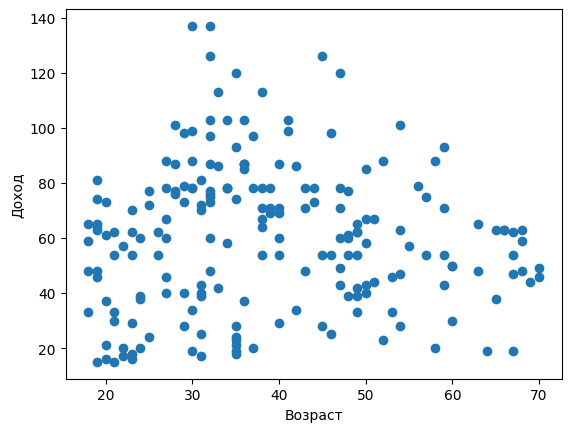

In [ ]:
plt.scatter(data['Age'], data['Annual Income (k$)'])
plt.xlabel('Возраст')
plt.ylabel('Доход')
plt.show()

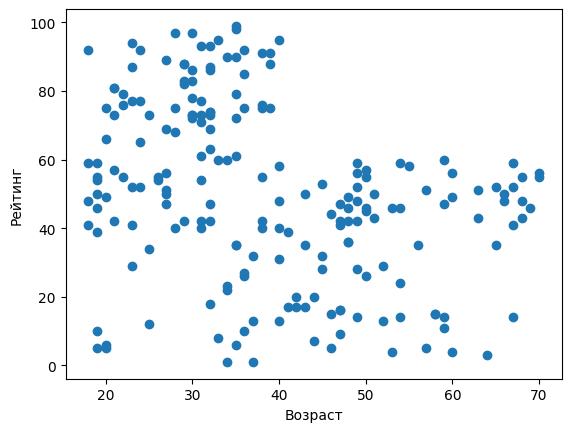

In [ ]:
plt.scatter(data['Age'], data['Spending Score (1-100)'])
plt.xlabel('Возраст')
plt.ylabel('Рейтинг')
plt.show()

Проведем очитску от выбросов. Уберем тех, у кого доход выше 110, а также тех, чей возраст меньше 30 и одновременно оценка меньше 20.

In [ ]:
data = data[data['Annual Income (k$)'] < 110]
data = data[(data['Age'] > 30) | (data['Spending Score (1-100)'] > 20)]

In [ ]:
X = scaler.fit_transform(data[["Age", "Annual Income (k$)", "Spending Score (1-100)"]])

In [ ]:
KMeans_draw_plot(random_state=20)

KMeans(random_state=20)

In [ ]:
KMeans_draw_plot(random_state=35)

KMeans(random_state=35)

In [ ]:
KMeans_draw_plot(random_state=17)

KMeans(random_state=17)

In [ ]:
KMeans_draw_plot(random_state=10)

KMeans(random_state=10)

In [ ]:
KmeansPP_draw_plot()

In [ ]:
KmeansPP_draw_plot()

In [ ]:
KmeansPP_draw_plot()

Как видно из графиков выше удаление выбросов не сильно улучшило стабильность кластеризации. Но тут скорее дело в количестве кластеров. Попробуем уменьшить количество кластеров и оценим их качество силуэтными коэффициентами.

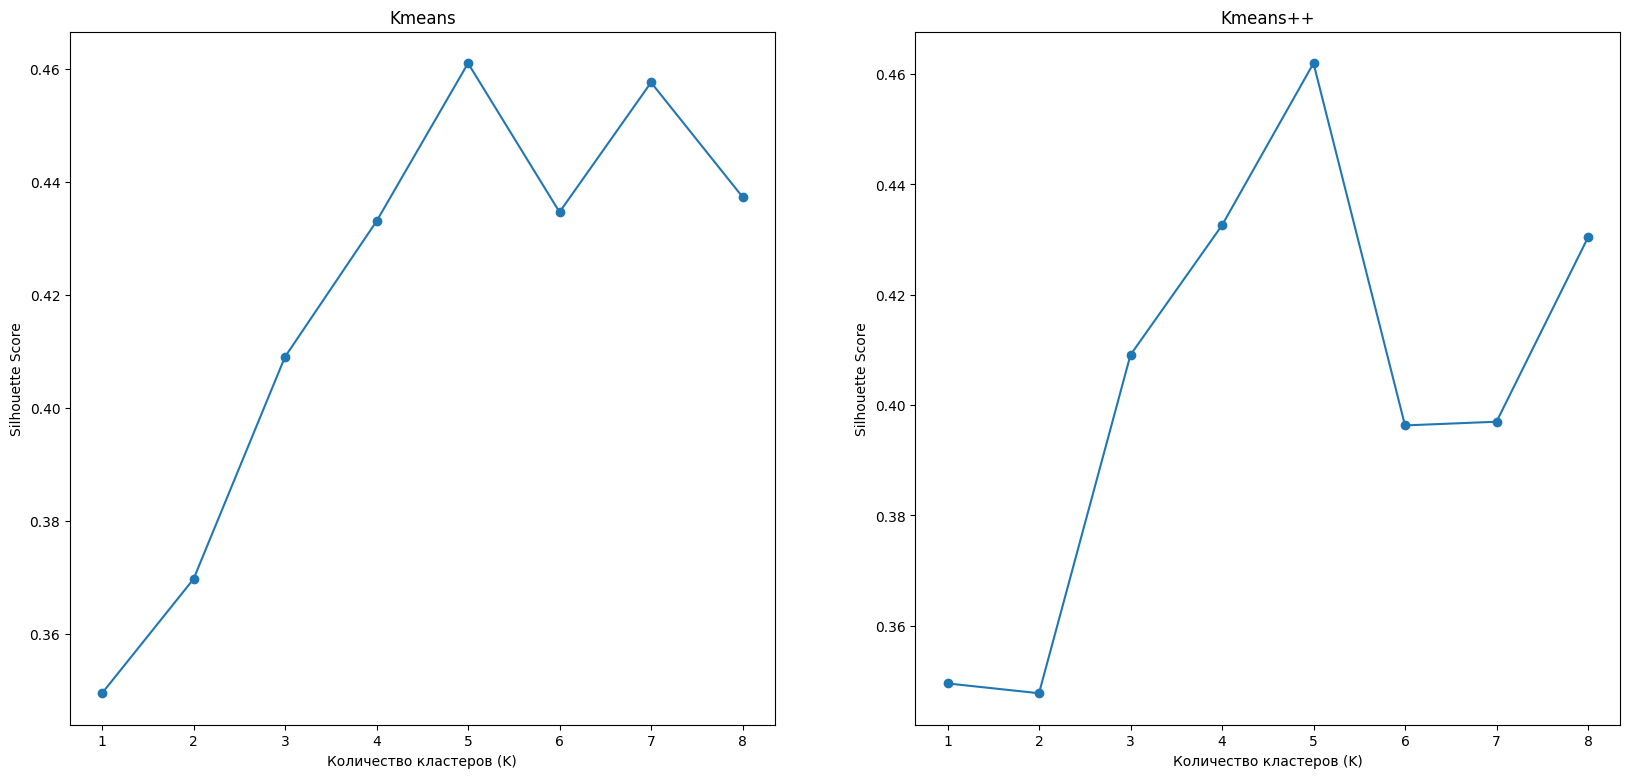

In [ ]:
silhouette_scores = []
silhouette_scores_PP = []

for i in range(9, 1, -1):
    Kmeans_PP = KmeansPP(n_clusters=i)
    kmeans = KMeans(n_clusters=i)

    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

    Kmeans_PP.fit(X)
    labels_PP = Kmeans_PP.labels
    score = silhouette_score(X, labels_PP)
    silhouette_scores_PP.append(score)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9), subplot_kw={'xlabel': 'Количество кластеров (K)', 'ylabel': 'Silhouette Score'})

ax1.plot(range(1, 9), silhouette_scores[::-1], marker='o',)
ax2.plot(range(1, 9), silhouette_scores_PP[::-1], marker='o')

ax1.set_title('Kmeans')
ax2.set_title('Kmeans++')

fig.show()

Если запустить код в ячейке выше несколько раз, то можно увидеть как постоянно меняется силуэтные коэффициенты. Наивысшие коэффициенты получаются в районе 4-7 кластеров.

**Создаем новые признаки**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187 entries, 0 to 191
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              187 non-null    int64 
 1   Gender                  187 non-null    object
 2   Age                     187 non-null    int64 
 3   Annual Income (k$)      187 non-null    int64 
 4   Spending Score (1-100)  187 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 8.8+ KB


In [ ]:
data['costs/income'] = data['Annual Income (k$)'] * np.random.sample()

In [ ]:
data.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),costs/income
0,1,Male,19,15,39,10.358209
1,2,Male,21,15,81,10.358209
3,4,Female,23,16,77,11.048756
4,5,Female,31,17,40,11.739303
5,6,Female,22,17,76,11.739303
6,7,Female,35,18,6,12.429851
7,8,Female,23,18,94,12.429851
8,9,Male,64,19,3,13.120398
9,10,Female,30,19,72,13.120398
10,11,Male,67,19,14,13.120398


In [ ]:
X = scaler.fit_transform(data[["Age", "Spending Score (1-100)", "costs/income"]])

In [ ]:
KMeans_draw_plot(n_clusters=5, random_state=20)

KMeans(n_clusters=5, random_state=20)

In [ ]:
KmeansPP_draw_plot(n_clusters=5)

5 кластеров и использование нового признака показывают неплохой результат.Но на графиках наблюдаются нечеткие границы между некоторыми кластерами. Возможно изменение параметра random_state поможет улучшить реультат. По методу kmeans++ можно разделить покапутелей на 5 категорий:
-  Молодые люди возрастом до 40 лет, c низким доходом(<40) и высокой оценкой(>60)
- Молодые люди до 40 лет, с доходом от низкого до среднего(<80) и оценкой от средней до низкой(<60)
- Взрослые люди старше 40 лет, с доходом от низкого до среднего(<70) и оценкой средней до низкой(<60)
- Люди с высоким доходом(>70), низкой оценкой(<40)
- Люди с высоким доходом(>70), высокой оценкой(>60)